# Distillation analysis for the muon g-2

In [1]:
import sys
print(sys.executable)
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.stats import f as fdist
from scipy.linalg import inv
user=os.environ['USER']
%autosave 60

/Users/thomasblum/Dropbox/python3.12/bin/python


Autosaving every 60 seconds


## Utils

In [2]:
def jackblocks(data,jacks,omit,prt=0):
    #loop over timeslices
    nconf=data.shape[0]
    nt=data.shape[1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            if i not in omit:
                sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = sum-data[i,j]
                jacks[n,j] *= norm
                n=n+1
# jackknife blocks of size bs>=1
def jackblocks_bs(data,bs=1):
    
    jacks=np.zeros([int(data.shape[0]/bs),data.shape[1]])
    nconf=data.shape[0]
    if nconf % bs:
        print("num confs not divisible by block size")
        return
    nt=data.shape[1]
    norm=1.0/(nconf-bs)
    # loop over timeslices
    for j in range(0,nt):
        #
        # sum over configs
        #
        sum=0.0
        for i in range(0,nconf):
            sum = sum + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf,bs):
            jacks[n,j] = sum
            for k in range(bs):
                jacks[n,j] -= data[i+k,j]
            jacks[n,j] *= norm
            n=n+1
            
    return jacks
#
# compute avg and jacknife error from a vector of jacknife blocks
def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err


def covariance(data):
    
    nconf,tsize=data.shape
    covmat=np.zeros((tsize,tsize))
    avg = np.average(data,axis=0)
    for n in range(nconf):
        covmat+=np.outer(data[n]-avg,data[n]-avg)
    covmat*=1/nconf
    covmat *= nconf-1
    
    return avg,covmat

def const_plus_exp(t,*p):

    return p[0]+p[1]*np.exp(-t*p[2])

def err_const_plus_exp(t,p,c):
    
    fact = np.exp(-t*p[2])
    errsq  =   c[0][0]
    errsq +=   c[1][1]*(fact)**2
    errsq +=   c[2][2]*((-t)*p[1]*fact)**2
    errsq += 2*c[0][1]*fact
    errsq += 2*c[0][2]*(-t)*p[1]*fact
    errsq += 2*c[1][2]*(-t)*p[1]*fact**2
    
    return np.sqrt(errsq)

def fqed(qsq,m):
    
    return  m**2*qsq*Z(qsq,m)**3*(1-qsq*Z(qsq,m))/(1 + m**2*qsq*Z(qsq,m)**2)

def Z(qsq,m):
    
    return (np.sqrt(qsq**2+4*m**2*qsq)-qsq)/2/m**2/qsq

# long distance window filter
def Theta(t1,t2):
    
    return (1+np.tanh((t1-t2)/Delta))/2

class Ensemble_jks:
    
    def __init__(self):
        self.Op=0 # operator list
        self.jks=0 # gevp correlator single jackknife blocks
        self.jks_ct_all=0 # lvec-lvec correlator single jackknife blocks
        self.double_jks=0 # correlator double jackknife blocks
        self.vec=0 # GEVP eigenvector double jackkife blocks
        self.e=0 # GEVP eigenvalue jackkife blocks
        self.amuOrig=0 # amu integrand for original correlator jackknife blocks
        self.amuRec=0 # amu integrand for reconstructed correlator jackknife blocks
        pass




## Global Input Parameters

In [3]:
alphaQED=1/137.035999074
fm = 1/0.1973269804
muon_mass=0.1056583755 # GeV
Delta=0.15

## Ensembles parameters

In [4]:
Ensemble='48I'
ainv=1.72
afm=1/fm/ainv
tv=8
numT=96
Zv=0.71097

### Operators

In [5]:
l48I=Ensemble_jks()

In [6]:
# these are the two pion and vector operators used in the GEVP
l48I.Op=['2pi.g5.0.0.1','2pi.g5.0.1.1','2pi.g5.1.1.1','2pi.g5.0.0.2','svec.gi','lvec.gi']

### Correlators

In [7]:
# This is the corresponding "matrix" correlation function (jackKnife blocks)
l48I.jks=np.load('48Ijks.npy')
numDist=l48I.jks.shape[2]

### GEVP

In [8]:
# GEVP under jackknife
NTfold=int(numT/2)
minOp=0
maxOp=5
tmin=4
tmax=16
l48I.e=np.zeros((numDist,NTfold,maxOp-minOp))
l48I.vec=np.zeros((numDist,NTfold,maxOp-minOp,maxOp-minOp))
folded=0.5*(l48I.jks+np.roll(np.flip(l48I.jks,axis=3),1,axis=3))
for n in range(numDist):
    for t in range(tmin,tmax):
        a=folded[minOp:maxOp,minOp:maxOp,n,t]
        b=folded[minOp:maxOp,minOp:maxOp,n,t-1]
        a=0.5*(a+np.conjugate(np.transpose(a)))
        b=0.5*(b+np.conjugate(np.transpose(b)))
        l48I.e[n,t],l48I.vec[n,t]=eigh(a,b,type=1)

/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/3310032787.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  l48I.e[n,t],l48I.vec[n,t]=eigh(a,b,type=1)


In [9]:
# do excited state fit under jackknife
npar=3
fitpars=np.zeros((maxOp,numDist,npar))
fitcov=np.zeros((maxOp,numDist,npar,npar))
tmax=[16]*maxOp
tmin=[5]*maxOp
tmax[4]=13
# jackknife the fit
csq=np.zeros((maxOp,numDist))
guess = ([0.25,1.,1])
for l in range(maxOp):
    #same cov mat for each block ("frozen")
    avg,cov=covariance(-np.log(l48I.e[:,tmin[l]:tmax[l],l]))
    dof=tmax[l]-tmin[l]-npar
    t=np.arange(tmin[l],tmax[l])
    for jk in range(numDist):
        val=-np.log(l48I.e[jk,tmin[l]:tmax[l],l])
        popt,pcov=curve_fit(const_plus_exp,t,val,sigma=cov, 
                            p0=guess, absolute_sigma=True)
        fitpars[l][jk] = popt
        fitcov[l][jk] = pcov
        theory = const_plus_exp(t, *popt)
        r = avg - theory
        csq[l][jk] = r.T @ inv(cov) @ r
    cs=jack(csq[l])
    F = fdist(dof,numDist-dof)
    p_value = 1 - F.cdf(cs[0]/dof/(numDist-1)*(numDist-dof))
    print('n, chi square, dof=',l,cs,dof)
    print('p-value=',p_value)

n, chi square, dof= 0 (6.58047619753164, 0.4437633037250746) 8
p-value= 0.7655547980767468
n, chi square, dof= 1 (4.742210110133821, 0.33653603718722186) 8
p-value= 0.8864469473754526
n, chi square, dof= 2 (6.465706425223414, 0.549650106471327) 8
p-value= 0.7736681697822423
n, chi square, dof= 3 (8.406748813613275, 0.49153458973594993) 8
p-value= 0.6347082204093193
n, chi square, dof= 4 (4.622866815855745, 0.42182639879276845) 5
p-value= 0.5732114073596604


(20,) (20,) (20,)
Energy= 0 0.5508608746510564 0.007526290225165433
Amp= 4.824559783261879 1.673347412547365
DeltaE= 0.6974416126485222 0.07872041772361335
(20,) (20,) (20,)
Energy= 1 0.49655036478200654 0.004454918246776296
Amp= 3.264427420042771 0.8846857873651772
DeltaE= 0.7020972616517204 0.0628502250335446
(20,) (20,) (20,)
Energy= 2 0.4559675224091049 0.0018971297064400872
Amp= 2.7479639181988254 0.529098607197035
DeltaE= 0.7820642155535329 0.04397562731161172
(20,) (20,) (20,)
Energy= 3 0.38854030399056 0.0009030193134805736
Amp= 2.4041524781787995 0.41390851778594856
DeltaE= 0.7887559346343456 0.03779363217759168
(20,) (20,) (20,)
Energy= 4 0.30448015584850824 0.0006557941569288282
Amp= 3.5506739191278363 0.5884252562235388
DeltaE= 0.9602575499096738 0.036164602632991476


/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/2383681796.py:22: RuntimeWarning: divide by zero encountered in log
  v,err=jack(-np.log(l48I.e[:,tmin:tmax,l]))
/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/2859662791.py:66: RuntimeWarning: invalid value encountered in subtract
  err+=(vec[i]-avg)*(vec[i]-avg)


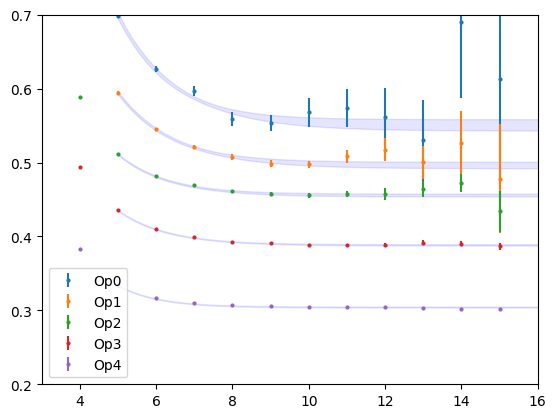

In [13]:
avg=np.average(l48I.e,axis=0)
# data range
tmin=4
tmax=24
t=np.arange(tmin,tmax)
# fit range
ftmin=5
ftmax=17
tc=np.zeros(int((ftmax-ftmin)/0.01))
cmat=np.zeros((3,3))
for i in range(int((ftmax-ftmin)/0.01)):
    tc[i]=ftmin+i*0.01
for l in range(maxOp):
    v=np.average(fitpars[l],axis=0)
    cmat=np.average(fitcov[l],axis=0)
    val=const_plus_exp(tc,*v)
    err=err_const_plus_exp(tc,v,cmat)
    vp = val+err
    vm = val-err
    plt.fill_between(tc,vp,vm,color='blue', alpha=0.1)
for l in range(maxOp):
    v,err=jack(-np.log(l48I.e[:,tmin:tmax,l]))
    print(t.shape,v.shape,err.shape)
    plt.errorbar(t,v,err,marker='o',linestyle='',markersize=2,label='Op'+str(l))
    v,err=jack(fitpars[l,:,0])
    print('Energy=',l,v,err)
    v,err=jack(fitpars[l,:,1])
    print('Amp=',v,err)
    v,err=jack(fitpars[l,:,2])
    print('DeltaE=',v,err)
plt.ylim(0.2,0.7)
plt.xlim(3,16)
plt.legend()
plt.savefig('gevp energies.png')

v,norm= 0 [-0.74386546 -0.24283865 -0.20093068 -0.0639276   0.58563673] 0.9997366903233704
err= 0 [0.01387046 0.01243214 0.03048198 0.06776769 0.03126489]
v,norm= 1 [-0.0237153   0.79292493  0.26220743  0.11131972 -0.53797599] 0.9998553302600017
err= 1 [0.00039698 0.01729505 0.02504438 0.04269054 0.03181876]
v,norm= 2 [ 0.01115356  0.24085662 -0.719359   -0.12974986  0.63826578] 0.9998319144587605
err= 2 [0.00046684 0.01028062 0.03692397 0.03387369 0.04187492]
v,norm= 3 [-0.00635265 -0.08292641 -0.73200871  0.10711227 -0.55037712] 0.8571419158575162
err= 3 [0.01323468 0.17268445 1.52273699 0.22679791 1.14636376]
v,norm= 4 [-0.00208146 -0.01659268 -0.03844838 -0.88318133 -0.27480828] 0.8572867777493847
err= 4 [0.00429782 0.03369136 0.08245061 1.83809156 0.56922009]


<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/2915748307.py:22: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(v,marker='o',color=color[i],linestyle='',markersize=3,label='$\lambda=$'+str(maxOp-1-i))


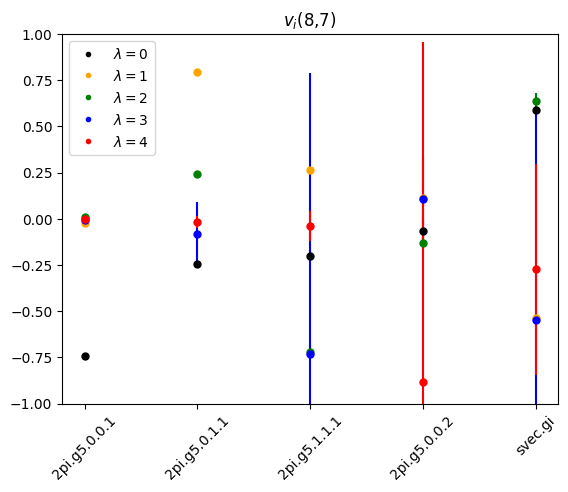

In [14]:
plt.xticks(np.arange(len(l48I.Op)), l48I.Op, rotation=45)
plt.ylim(-1,1)
color=['red','blue','green','orange','black']
x=0
# timeslice of v, i.e. use v(tv,tv-1)
tv=8
tvec=np.zeros((numDist,NTfold,maxOp-minOp,maxOp-minOp))
sign0=np.zeros(maxOp,dtype=int)
sign=np.zeros(maxOp,dtype=int)
idx=np.zeros(maxOp,dtype=int)
tvec = l48I.vec
for jk in range(numDist):
    for n in range(maxOp):
        # normalize eigenvectors (GEVP norms to v^dag.C.v=1)
        tvec[jk,tv,:,n]=tvec[jk,tv,:,n]/np.sqrt(np.inner(tvec[jk,tv,:,n],tvec[jk,tv,:,n]))

# c_ni, reverse order of label for plot
for i in range(maxOp-1,-1,-1):
    v,err=jack(tvec[:,tv,:,i])
    print('v,norm=',maxOp-1-i,v,np.inner(v,v))
    print('err=',maxOp-1-i,err)
    plt.plot(v,marker='o',color=color[i],linestyle='',markersize=3,label='$\lambda=$'+str(maxOp-1-i))
    for j in range(maxOp):
        x=j
        plt.errorbar(x,v[j],err[j],marker='o',color=color[i],linestyle='',markersize=5)
plt.title('$v_i($'+str(tv)+','+str(tv-1)+')')
plt.legend()

/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/495935871.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[c,t,n]=tt**2/ttt


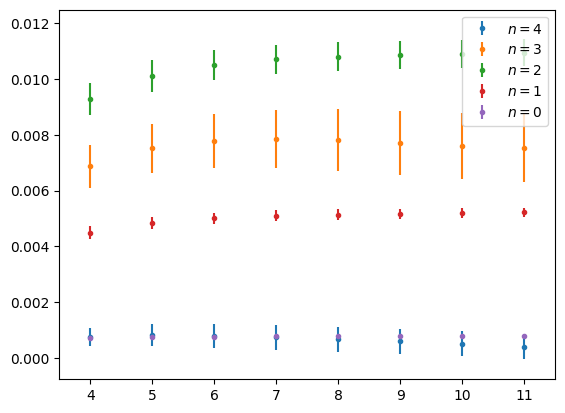

In [15]:

corr=np.zeros((numDist,numT,maxOp))
# local vector:
op=5
tvec=np.zeros((numDist,NTfold,maxOp-minOp,maxOp-minOp))
for c in range(numDist):
    tvec = l48I.vec
    for t in range(tmin,tmax):
        for n in range(maxOp):
            energy=fitpars[n,c,0]
            tt=0
            ttt=0
            for i in range(maxOp):
                tt += tvec[c,tv,i,n]*l48I.jks[op,i,c,t]*np.exp(energy*t)
                tt += tvec[c,tv,i,n]*l48I.jks[i,op,c,t]*np.exp(energy*t)
                for j in range(maxOp):
                    ttt += tvec[c,tv,i,n]*tvec[c,tv,j,n]*l48I.jks[i,j,c,t]*np.exp(energy*t)
            tt /= 2
            corr[c,t,n]=tt**2/ttt
#plot
t=np.arange(0,tmax)
#plt.ylim(0,0.012)
plt.xlim(3.5,11.5)
#plt.yscale('log')
for n in range(0,maxOp):
    v,err=jack(corr[:,0:tmax,n])
    plt.errorbar(t,v,err,marker='o',linestyle='',markersize=3,label='$n=$'+str(maxOp-1-n))
    t=t+0.
plt.legend()

$|\langle 0 | O_V |n\rangle|^2=\frac{(v_{i,n} C_{V,i})^2}{v_{in}v_{j,n}C_{i,j}}$ (see Alpha collaboration paper https://iopscience.iop.org/article/10.1088/1126-6708/2009/04/094/pdf)

where $v_{i,n}O_i|0\rangle = A_n |n\rangle$, i.e., it creates eigenstate n. $A_n$ is c- number. Assumed Einstein summation convention

/var/folders/fp/rjrtmzhj03z5kr3pybmmdpn40000gn/T/ipykernel_42208/2292182008.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[c,t,tv-mintv,n]=tt**2/ttt


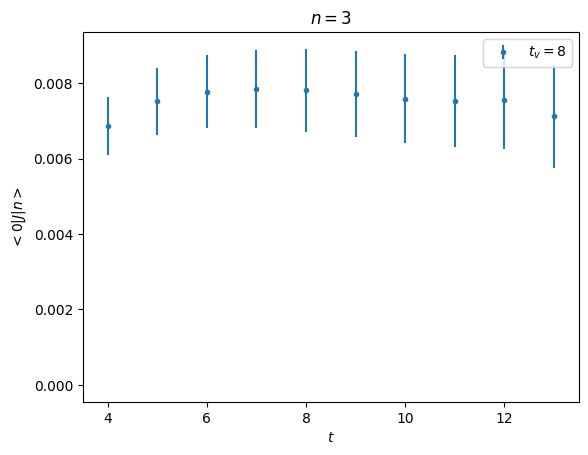

In [16]:
mintv=8
maxtv=9
corr=np.zeros((numDist,numT,maxtv-mintv,maxOp))
# local vector:
op=5
tvec=np.zeros((numDist,NTfold,maxOp-minOp,maxOp-minOp))
for c in range(numDist):
    tvec = l48I.vec
    for t in range(tmin,tmax):
        for n in range(maxOp):
            energy=fitpars[n,c,0]
            for tv in range(mintv,maxtv):
                tt=0
                ttt=0
                for i in range(maxOp):
                    tt += tvec[c,tv,i,n]*l48I.jks[op,i,c,t]*np.exp(energy*t)
                    tt += tvec[c,tv,i,n]*l48I.jks[i,op,c,t]*np.exp(energy*t)
                    for j in range(maxOp):
                        ttt += tvec[c,tv,i,n]*tvec[c,tv,j,n]*l48I.jks[i,j,c,t]*np.exp(energy*t)
                tt /= 2
                corr[c,t,tv-mintv,n]=tt**2/ttt
#plot
color=['red','blue','green','orange','black']
t=np.arange(0,tmax)
#plt.ylim(0,0.012)
plt.xlim(3.5,13.5)
#plt.yscale('log')
n=1
for tv in range(maxtv-mintv):
    v,err=jack(corr[:,0:tmax,tv,n])
    plt.errorbar(t,v,err,marker='o',linestyle='',markersize=3,label='$t_v=$'+str(tv+mintv))
    t=t+0.1
plt.title('$n=$'+str(maxOp-1-n))
plt.xlabel('$t$')
plt.ylabel('$< 0 |J|n >$')
plt.legend()

In [17]:
jks_ct=np.load('jks_ct.npy')
l48I.jks_ct_all=np.load('jks_ct_all.npy')
l48I.jks_lc_ll_ratio=np.load('jks_lc_ll_ratio.npy')

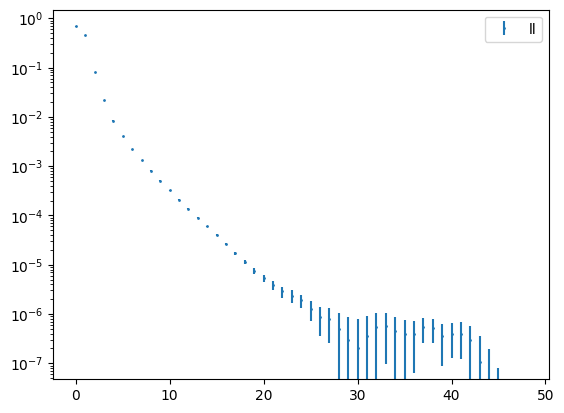

In [18]:
# local-local 
# already folded
plt.yscale('log')
v,err=jack(jks_ct)
plt.errorbar(np.arange(numT/2+1),v,err,marker='o',linestyle='',markersize=1,label='ll')
plt.legend()

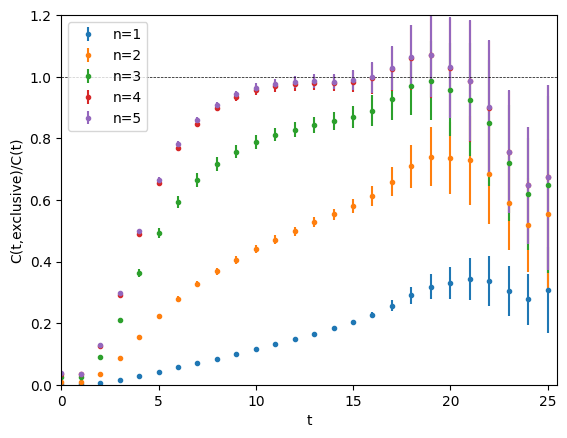

In [20]:
tv=8
recon_corr2=np.zeros((numDist,NTfold))
for n in range(maxOp-1,-1,-1):
    for t in range (NTfold):
        for jk in range (numDist):
            recon_corr2[jk,t] += corr[jk,tv,tv-mintv,n] * np.exp(-fitpars[n,jk,0]*t)/jks_ct[jk,t]
    v,err=jack(recon_corr2)
    plt.errorbar(np.arange(NTfold),v,err,marker='o',linestyle='',markersize=3,label='n='+str(4-n+1))
plt.xlim(0,25.5)
plt.ylim(0,1.2)
plt.hlines(1.0,0,33,linestyle='dashed',color='black',linewidth=0.5)
plt.xlabel('t')
plt.ylabel('C(t,exclusive)/C(t)')
plt.legend()
plt.savefig('compare correlators.png')

In [ ]:
plt.yscale('log')
v,err=jack(l48I.jks_ct_all)
plt.errorbar(np.arange(NTfold+1),v,err,marker='o',linestyle='',markersize=1,label='ll')
plt.legend()

In [ ]:
# local-conserved to local-local ratio 
# already folded
#plt.yscale('log')
plt.ylim(0.5,0.8)
plt.xlim(0.0,2.5)
v,err=jack(l48I.jks_lc_ll_ratio)
plt.errorbar(np.arange(NTfold+1)*afm,v,err,marker='o',linestyle='',markersize=2,label='ll')
plt.legend()

In [ ]:
SuperJackSize=l48I.jks_ct_all.shape[0]
gevpList=[1000,1080,1200,1280,1360,1440,1520,1600,1680,1760,1840,1960,2040,2160,1040,1160,1240,1320,1400,1480,1560,1640,1720,1800,1880,2000,2080]
print(len(gevpList))
print(SuperJackSize)

In [ ]:
corrList=[
640,
680,
720,
740,
760,
780,
800,
820,
840,
860,
880,
900,
920,
940,
960,
975,
985,
980,
990,
995,
1000,
1002,
1005,
1007,
1010,
1012,
1015,
1017,
1020,
1022,
1025,
1027,
1030,
1032,
1035,
1037,
1040,
1042,
1045,
1047,
1050,
1052,
1055,
1057,
1060,
1062,
1065,
1067,
1070,
1072,
1075,
1077,
1080,
1082,
1085,
1087,
1090,
1092,
1095,
1097,
1100,
1102,
1105,
1107,
1110,
1112,
1115,
1117,
1120,
1122,
1125,
1127,
1130,
1132,
1135,
1137,
1140,
1142,
1145,
1147,
1150,
1152,
1155,
1157,
1160,
1162,
1165,
1167,
1170,
1172,
1175,
1177,
1180,
1182,
1185,
1187,
1190,
1192,
1195,
1197,
1200,
1202,
1205,
1207,
1210,
1212,
1215,
1217,
1220,
1222,
1225,
1227,
1230,
1232,
1235,
1237,
1240,
1242,
1245,
1247,
1250,
1252,
1255,
1257,
1260,
1262,
1265,
1267,
1270,
1272,
1275,
1277,
1280,
1282,
1285,
1287,
1290,
1292,
1295,
1297,
1300,
1302,
1305,
1307,
1310,
1312,
1315,
1317,
1320,
1322,
1325,
1327,
1330,
1332,
1335,
1337,
1340,
1342,
1345,
1347,
1350,
1352,
1355,
1357,
1360,
1362,
1365,
1367,
1370,
1375,
1377,
1380,
1385,
1387,
1390,
1395,
1397,
1400,
1405,
1407,
1410,
1415,
1417,
1420,
1425,
1427,
1430,
1435,
1437,
1440,
1445,
1447,
1450,
1455,
1457,
1460,
1465,
1467,
1470,
1475,
1477,
1480,
1485,
1487,
1490,
1495,
1497,
1500,
1505,
1507,
1510,
1515,
1517,
1520,
1525,
1527,
1530,
1535,
1537,
1540,
1545,
1547,
1550,
1555,
1557,
1560,
1565,
1567,
1570,
1575,
1577,
1580,
1585,
1587,
1590,
1595,
1597,
1600,
1605,
1607,
1610,
1615,
1617,
1620,
1625,
1627,
1630,
1635,
1637,
1640,
1645,
1647,
1650,
1655,
1657,
1660,
1665,
1667,
1670,
1675,
1677,
1680,
1685,
1687,
1690,
1695,
1697,
1700,
1705,
1707,
1710,
1715,
1717,
1720,
1725,
1727,
1730,
1735,
1737,
1740,
1745,
1747,
1750,
1755,
1757,
1760,
1765,
1767,
1770,
1775,
1777,
1780,
1785,
1787,
1790,
1795,
1797,
1800,
1805,
1807,
1810,
1815,
1817,
1820,
1825,
1827,
1830,
1835,
1837,
1840,
1845,
1847,
1850,
1855,
1857,
1860,
1865,
1870,
1875,
1877,
1880,
1885,
1887,
1890,
1895,
1897,
1900,
1905,
1907,
1910,
1915,
1917,
1920,
1925,
1927,
1930,
1935,
1940,
1945,
1950,
1955,
1960,
1965,
1970,
1975,
1980,
1985,
1990,
1995,
2000,
2005,
2010,
2015,
2020,
2025,
2030,
2035,
2040,
2045,
2050,
2055,
2060,
2065,
2070,
2075,
2080,
2085,
2090,
2095,
2100,
2105,
2110,
2115,
2120,
2125,
2130,
2135,
2140,
2145,
2150,
2155,
2160,
2165,
2175,
2185,
2195]
print(len(corrList))

In [ ]:
l48I.recon_corr=np.zeros((SuperJackSize,NTfold+1,maxtv-mintv))
for tv in range(mintv,maxtv):
    ttv=tv-mintv
    recon_corr=np.zeros((numDist,NTfold+1))
    for t in range (NTfold+1):
        temp_corr=np.zeros(numDist)
        for j in range (numDist):
            for n in range(maxOp-1,-1,-1):
                temp_corr[j] += corr[j,tv,ttv,n] * np.exp(-fitpars[n,j,0]*t)
            recon_corr[j,t]=temp_corr[j]
    avg=np.average(recon_corr,axis=0)
    for j in range(SuperJackSize):
        l48I.recon_corr[j,:,ttv]=avg
    n=0
    for num in corrList:
        m=0
        for num2 in gevpList:
            if num==num2:
                l48I.recon_corr[n,:,ttv]=recon_corr[m]
            m+=1
        n+=1

### LD part of $a_\mu$

In [ ]:
# compute amu for two light flavors with q=2/3, -1/3
# for all t using original C(t)
# and do superjack
l48I.amuRec=np.zeros(l48I.recon_corr.shape)
l48I.wt=np.zeros((SuperJackSize,l48I.recon_corr.shape[1]))
fact = 2*4*5/9*alphaQED**2*10**10
for t in range(NTfold+1):
    n=0
    for j in range(SuperJackSize):
        mmu=muon_mass/ainv
        # the QED kernel in euclidean time
        l48I.wt[j,t] = quad(lambda x: ((np.cos(np.sqrt(x)*t)-1)/x+0.5*t**2)*fqed(x,mmu), 0, np.inf)[0]
        l48I.amuRec[j,t]= l48I.recon_corr[j,t] * l48I.wt[j,t] * Theta(t*afm,1.0)
        l48I.amuRec[j,t] *= Zv**2
l48I.amuRec *= fact

In [ ]:
# compute amu for two light flavors with q=2/3, -1/3
# for all t using original C(t)
# and do superjack
l48I.amuOrig=np.zeros((SuperJackSize,l48I.jks_ct_all.shape[1]))
fact = 2*4*5/9*alphaQED**2*10**10
for t in range(NTfold+1):
    for j in range(SuperJackSize):
        mmu=muon_mass/ainv
        l48I.amuOrig[j,t]= l48I.jks_ct_all[j,t] * l48I.wt[j,t] * Theta(t*afm,1.0)
        l48I.amuOrig[j,t] *= Zv**2
l48I.amuOrig *= fact

In [ ]:
plt.xlabel('$t$')
plt.ylabel('$C$(t)$w$(t)')
plt.ylim(0,170)
val,err=jack(l48I.amuOrig)
plt.errorbar(np.arange(NTfold+1),val,err,color='orange',marker='o',linestyle='',markersize=1,label='original')
for tv in range(1):
    val,err=jack(l48I.amuRec[:,:,tv])
    plt.errorbar(np.arange(NTfold+1),val,err,color='blue',marker='o',linestyle='',markersize=1,label='reconstructed tv '+str(tv+mintv))
plt.legend()
plt.savefig('scratch/48I_summand.pdf')

In [ ]:
# compute amu for two light flavors with q=2/3, -1/3
l48I.sum=np.zeros(l48I.amuRec.shape)
for tv in range(1):
    for t in range(NTfold):
        for t2 in range(t+1):
            l48I.sum[:,t,tv] += l48I.amuOrig[:,t2]
        for t2 in range(t+1,int(numT/2+1)):
            l48I.sum[:,t,tv] += l48I.amuRec[:,t2,tv]

for tv in range(1):
    val,err=jack(l48I.sum[:,16,tv])
    plt.errorbar(tv+mintv,val,err,color='blue',marker='o',linestyle='',markersize=3,label='reconstructed')
plt.ylim(1460,1580)
plt.xlim(3,15)
plt.xlabel('t overlap')